# Task 3.1 - Analysis Report Preparation (part 2)

This notebook contains the solution to Task 3.1 (part 2)

## Post-Test Analysis Overview

Based on the results of the test presented in the file **Task_3_1_AB_analysis**, a negative impact on DAU and Retention D7 was observed. To understand the potential reasons behind these effects, I formulated several hypotheses to investigate further.

This section presents a post-analysis of the A/B test results reported in **Task_3_1_AB_analysis**. In this document, I examine the following hypotheses:

1. **Combat Effectiveness and Game Progression:**  
   - Hypothesis: The change led to a decrease in player effectiveness in Group A, reflected by lower damage dealt and fewer kills per battle among new players compared to the control group.  
   - Approach: Compare average values of `damage_dealt` and `kills_made` per battle for new players in both test and control groups.  
   - Hypothesis: The change negatively impacted player progression, with players in Group A having lower vehicle levels (`vehicle_lvl`).  
   - Approach: Compare the distribution of vehicle levels among new players in both groups one week after registration.

2. **Impact of the Change on Player Segments:**  
   - Hypothesis: The change affected different player segments (`player_group`) differently.  
   - Approach: Analyze key metrics such as retention, DAU, damage dealt, and kills made across segments defined by player status (new vs. returning), vehicle level, and battle duration (high vs. low).

In [10]:
import os
from typing import List, Sequence, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from dotenv import load_dotenv
from scipy.stats import ks_2samp, kstest, levene, mannwhitneyu, ttest_ind
from sqlalchemy import create_engine, text
from statsmodels.stats.proportion import proportions_ztest
from tqdm import tqdm

In [27]:
env_path = "/Users/alena/MyPythonProjects/dataPS.env"
load_dotenv(dotenv_path=env_path)

db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_host = os.getenv("DB_HOST", "localhost")
db_port = os.getenv("DB_PORT", "5432")
db_name = os.getenv("DB_NAME")

In [17]:
engine = create_engine(
    f"postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"
)

### Data aggregation in PostgresSQL

In [219]:
sample_data = text(
    """
SELECT
    player_id,
    player_group,
    COUNT(DISTINCT battle_id) AS battles_count,
    AVG(damage_dealt) AS avg_damage_per_battle,
    AVG(kills_made) AS avg_kills_per_battle,
    AVG(in_battle_presence_time) AS avg_presence_time,
    AVG(vehicle_lvl) AS avg_vehicle_lvl,
    MIN(account_created_at_d) AS account_created_at
FROM battles 
WHERE dt_d >= '2022-10-27'
GROUP BY
    player_id,
    player_group;
    """
)
with engine.connect() as conn:
    df_sample_data = pd.read_sql(sample_data, conn)

In [176]:
sample_dau = text(
    """
  SELECT 
  	dt_d, 
  	player_group, 
	CASE WHEN account_created_at_d >= '2022-10-27' THEN 'new' ELSE 'old' END AS new_status,
	COUNT(DISTINCT player_id) AS daily_dau
  FROM battles
  WHERE dt_d >= '2022-10-27'
  GROUP BY dt_d, player_group, new_status;
"""
)

with engine.connect() as conn:
    df_sample_dau = pd.read_sql(sample_dau, conn)

In [174]:
retentiond7_test = text(
    """
WITH base AS (
  SELECT DISTINCT 
    player_id, 
    player_group, 
    account_created_at_d,
	CASE WHEN account_created_at_d >= '2022-10-27' THEN 'new' ELSE 'old' END AS new_status
  FROM battles
  WHERE dt_d >= '2022-10-27'
),

activity_d7 AS (
  SELECT DISTINCT battles.player_id, new_status
  FROM battles
  
  INNER JOIN base 
  	ON battles.player_id = base.player_id
	  
  WHERE battles.dt_d = base.account_created_at_d + INTERVAL '7 days'
)

SELECT distinct
  base.player_group,
  base.new_status,
  COUNT(DISTINCT base.player_id) AS total_users,
  COUNT(DISTINCT a.player_id) AS retained_users,
  ROUND(COUNT(DISTINCT a.player_id)::numeric / COUNT(DISTINCT base.player_id), 4) AS retention_d7
FROM base

LEFT JOIN activity_d7 a 
	ON base.player_id = a.player_id
	
GROUP BY base.player_group, base.new_status;
"""
)

with engine.connect() as conn:
    df_retentiond7_test = pd.read_sql(retentiond7_test, conn)

### Helper functions

In [49]:
def get_column_by_player_groups(
    df: pd.DataFrame, column_name: str
) -> tuple[pd.Series, pd.Series]:
    """
    Extract data from a specific column for two player groups (A and B).

    Args:
        df (pd.DataFrame): The input DataFrame containing player data.
        column_name (str): The name of the column to extract data from.

    Returns:
        tuple[pd.Series, pd.Series]: A tuple containing two pandas Series:
            - First Series: Data for player group A
            - Second Series: Data for player group B
    """
    group_a = df[df["player_group"] == "A"][column_name]
    group_b = df[df["player_group"] == "B"][column_name]
    return group_a, group_b


def bootstrap_diff_mean(
    a: np.ndarray, b: np.ndarray, n_bootstrap: int, confidence_level: float = 0.95
) -> Tuple[float, float, bool, List[float]]:
    """
    Performs bootstrap resampling to estimate the confidence interval for the difference in means.

    Args:
        a: First sample data
        b: Second sample data
        n_bootstrap: Number of bootstrap iterations
        confidence_level: Confidence level for the interval (default: 0.95)

    Returns:
        Tuple containing:
        - lower: Lower bound of the confidence interval
        - upper: Upper bound of the confidence interval
        - is_significant: Whether the difference is statistically significant
        - diffs: List of all bootstrap differences
    """
    diffs = []
    for _ in range(n_bootstrap):
        sample_a = np.random.choice(a, size=len(a), replace=True)
        sample_b = np.random.choice(b, size=len(b), replace=True)
        diff = sample_b.mean() - sample_a.mean()
        diffs.append(diff)
    lower = np.percentile(diffs, (1 - confidence_level) / 2 * 100)
    upper = np.percentile(diffs, (1 + confidence_level) / 2 * 100)
    is_significant = not (lower <= 0 <= upper)
    return lower, upper, is_significant, diffs


def fpr_check(
    df: pd.DataFrame,
    column_usr: str,
    column_name: str,
    n_iterations: int = 1000,
    n_bootstrap_samples: int = 1000,
    alpha: float = 0.05,
) -> float:
    """
    Calculate the False Positive Rate (FPR) using bootstrap resampling.

    This function performs random permutations of player groups and uses bootstrap
    sampling to estimate the false positive rate when testing for differences
    between two groups.

    Args:
        df: DataFrame containing the data
        column_usr: Name of the column for agregate
        column_name: Name of the column to analyze
        n_iterations: Number of permutation iterations (default: 1000)
        n_bootstrap_samples: Number of bootstrap samples per iteration (default: 1000)
        alpha: Significance level for confidence interval (default: 0.05)

    Returns:
        float: The calculated false positive rate
    """
    # Get data
    df_copy = df.copy()
    group_a, group_b = get_column_by_player_groups(df_copy, column_name)

    # Get group sizes
    player_ids = df_copy[column_usr].unique()
    group_a_size = len(np.unique(group_a))
    group_b_size = len(np.unique(group_b))

    # Counter for false positives
    false_positive_count = 0

    for _ in tqdm(range(n_iterations)):
        # Randomly shuffle IDs and split into groups
        shuffled_ids = np.random.permutation(player_ids)
        group_a_ids = shuffled_ids[:group_a_size]
        group_b_ids = shuffled_ids[group_a_size : group_a_size + group_b_size]

        # Extract values for each group
        group_a_values = df_copy[df_copy[column_usr].isin(group_a_ids)][
            column_name
        ].values
        group_b_values = df_copy[df_copy[column_usr].isin(group_b_ids)][
            column_name
        ].values

        ci_lower, ci_upper, is_significant, bootstrap_diffs = bootstrap_diff_mean(
            group_a_values, group_b_values, n_bootstrap_samples
        )
        # Check if 0 is outside the confidence interval (false positive)
        if is_significant:
            false_positive_count += 1

    # Calculate final FPR
    fpr = false_positive_count / n_iterations
    return fpr


def plot_distribution_analysis(
    data: pd.Series,
    title_prefix: str = "Distribution Analysis",
    color: str = "skyblue",
    bins: int = 20,
    figsize: tuple = (12, 5),
) -> None:
    """
    Creates a visualization with histogram (with KDE) and QQ-plot for the given data.

    Args:
        data (pd.Series): The data to analyze and visualize
        title_prefix (str): Prefix for plot titles
        color (str): Color for the histogram
        bins (int): Number of bins for the histogram
        figsize (tuple): Figure size as (width, height)

    Returns:
        None: This function displays the plots directly
    """
    # Create figure with two subplots
    plt.figure(figsize=figsize)

    # Plot histogram with KDE
    plt.subplot(1, 2, 1)
    sns.histplot(data, kde=True, bins=bins, color=color)
    plt.title(f"{title_prefix} - Histogram")
    plt.xlabel(data.name)
    plt.ylabel("Frequency")

    # Plot QQ-plot
    plt.subplot(1, 2, 2)
    stats.probplot(data, dist="norm", plot=plt)
    plt.title(f"{title_prefix} - QQ-Plot")

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

# 1. Combat Effectiveness and Game Progression

Sampling validation has already been conducted and is documented in Task_3_1_AB_analysis. Hence, this analysis starts from distribution diagnostics and statistical test selection.

- Hypothesis: The change led to a decrease in player effectiveness in Group A, reflected by lower damage dealt and fewer kills per battle among new players compared to the control group.

### Metrics damage dealt per battle

In [60]:
group_a, group_b = get_column_by_player_groups(df_sample_data, "avg_damage_per_battle")

print("Analys Group A:")
stat, p_value = stats.normaltest(group_a.dropna())

if p_value < 0.05:
    print(
        f"The data is not normally distributed. Statistic: {stat}, p-value: {p_value}"
    )
else:
    print(
        f"The data can be normally distributed. Statistic: {stat}, p-value: {p_value}"
    )

print("\nAnalys Group B:")
stat, p_value = stats.normaltest(group_b.dropna())

if p_value < 0.05:
    print(
        f"The data is not normally distributed. Statistic: {stat}, p-value: {p_value}"
    )
else:
    print(
        f"The data can be normally distributed. Statistic: {stat}, p-value: {p_value}"
    )

Analys Group A:
The data is not normally distributed. Statistic: 296.94327879236926, p-value: 3.3081583619413973e-65

Analys Group B:
The data is not normally distributed. Statistic: 308.23949594595246, p-value: 1.1658532910965662e-67


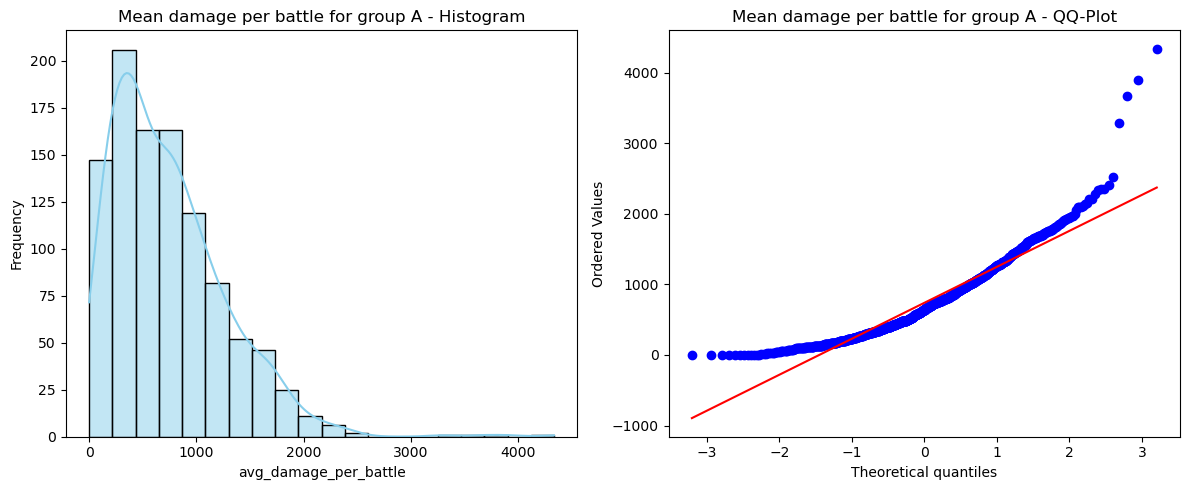

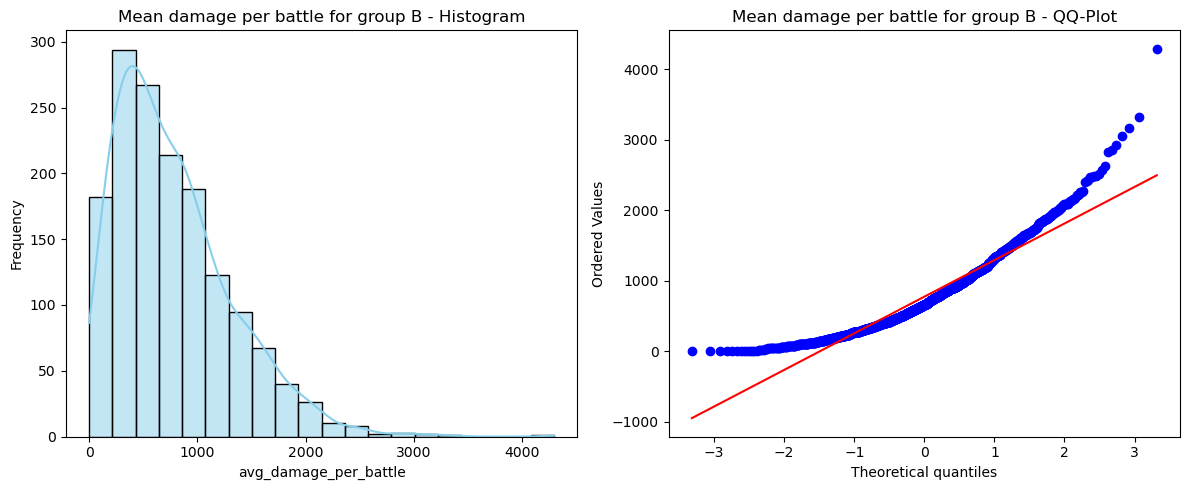

In [65]:
group_a, group_b = get_column_by_player_groups(df_sample_data, "avg_damage_per_battle")

plot_distribution_analysis(group_a, title_prefix="Mean damage per battle for group A")
plot_distribution_analysis(group_b, title_prefix="Mean damage per battle for group B")

#### Metric Distribution & Statistical Test Selection for metric - Mean damage per battle

Based on the results of the Normal test and visualization, the distribution of the metric *mean damage per battle* in both groups does not follow a normal distribution. As a result, standard parametric methods (e.g., t-test) are not suitable for computing the p-value.

Instead, I will use **bootstrapping** to estimate the distribution of the difference between groups and calculate a confidence interval for this difference.

### Metrics kills made per battle

In [71]:
group_a, group_b = get_column_by_player_groups(df_sample_data, "avg_kills_per_battle")

print("Analys Group A:")
stat, p_value = stats.normaltest(group_a.dropna())

if p_value < 0.05:
    print(
        f"The data is not normally distributed. Statistic: {stat}, p-value: {p_value}"
    )
else:
    print(
        f"The data can be normally distributed. Statistic: {stat}, p-value: {p_value}"
    )

print("\nAnalys Group B:")
stat, p_value = stats.normaltest(group_b.dropna())

if p_value < 0.05:
    print(
        f"The data is not normally distributed. Statistic: {stat}, p-value: {p_value}"
    )
else:
    print(
        f"The data can be normally distributed. Statistic: {stat}, p-value: {p_value}"
    )

Analys Group A:
The data is not normally distributed. Statistic: 639.1943361456683, p-value: 1.5874990499664256e-139

Analys Group B:
The data is not normally distributed. Statistic: 1081.319483288628, p-value: 1.5647956013351149e-235


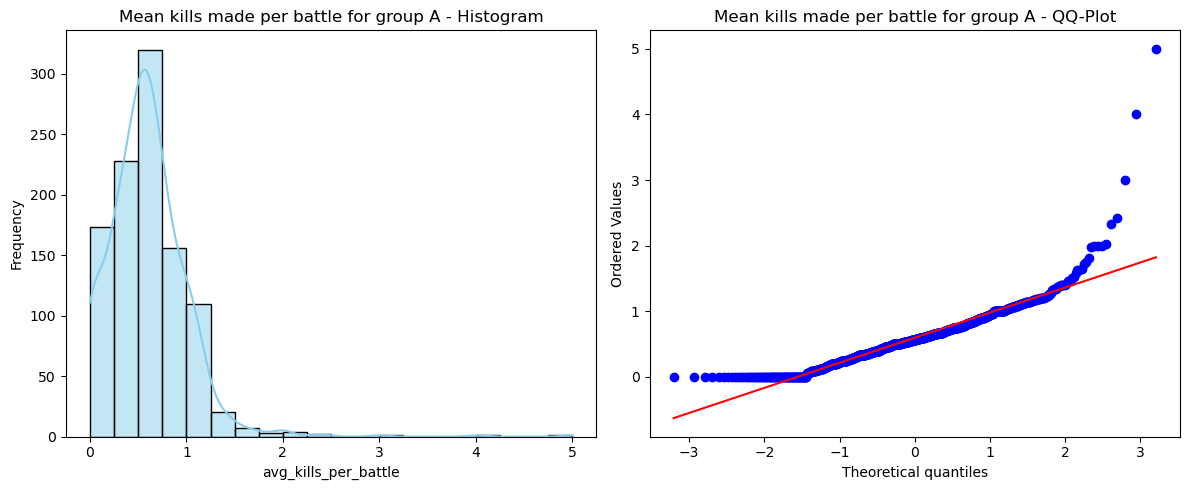

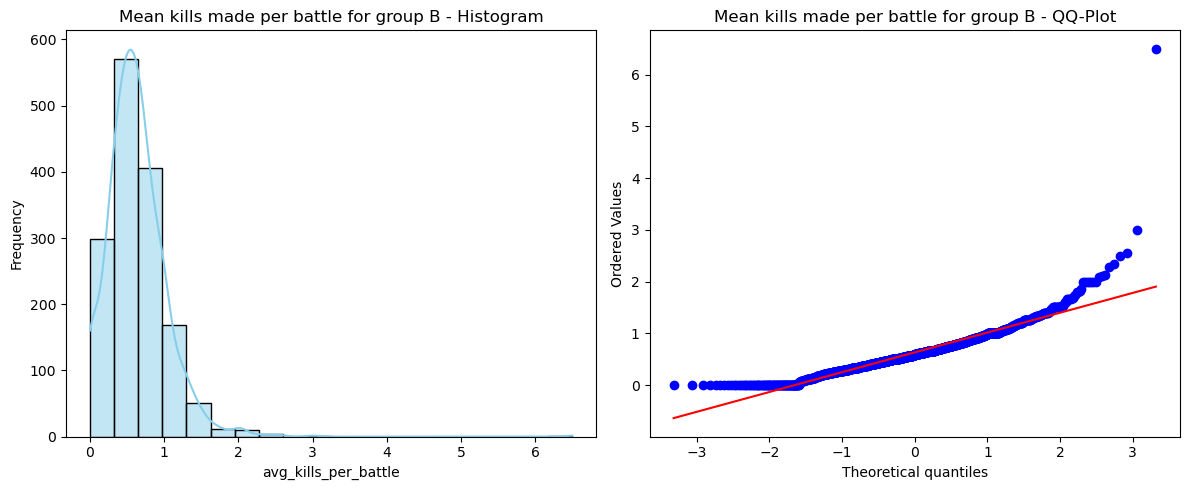

In [75]:
plot_distribution_analysis(
    group_a, title_prefix="Mean kills made per battle for group A"
)
plot_distribution_analysis(
    group_b, title_prefix="Mean kills made per battle for group B"
)

#### Metric Distribution & Statistical Test Selection for metric - Mean kills made per battle

Based on the results of the Normal test and visualization, the distribution of the metric *Mean kills made per battle* in both groups does not follow a normal distribution. As a result, standard parametric methods (e.g., t-test) are not suitable for computing the p-value.

Instead, I will use **bootstrapping** to estimate the distribution of the difference between groups and calculate a confidence interval for this difference.

### Metrics vehicle lvl

In [94]:
group_a, group_b = get_column_by_player_groups(df_sample_data, "avg_vehicle_lvl")

print("Analys Group A:")
stat, p_value = stats.normaltest(group_a.dropna())

if p_value < 0.05:
    print(
        f"The data is not normally distributed. Statistic: {stat}, p-value: {p_value}"
    )
else:
    print(
        f"The data can be normally distributed. Statistic: {stat}, p-value: {p_value}"
    )

print("\nAnalys Group B:")
stat, p_value = stats.normaltest(group_b.dropna())

if p_value < 0.05:
    print(
        f"The data is not normally distributed. Statistic: {stat}, p-value: {p_value}"
    )
else:
    print(
        f"The data can be normally distributed. Statistic: {stat}, p-value: {p_value}"
    )

Analys Group A:
The data is not normally distributed. Statistic: 82.32012296765937, p-value: 1.3317184688590194e-18

Analys Group B:
The data is not normally distributed. Statistic: 102.2636554192463, p-value: 6.219126291250029e-23


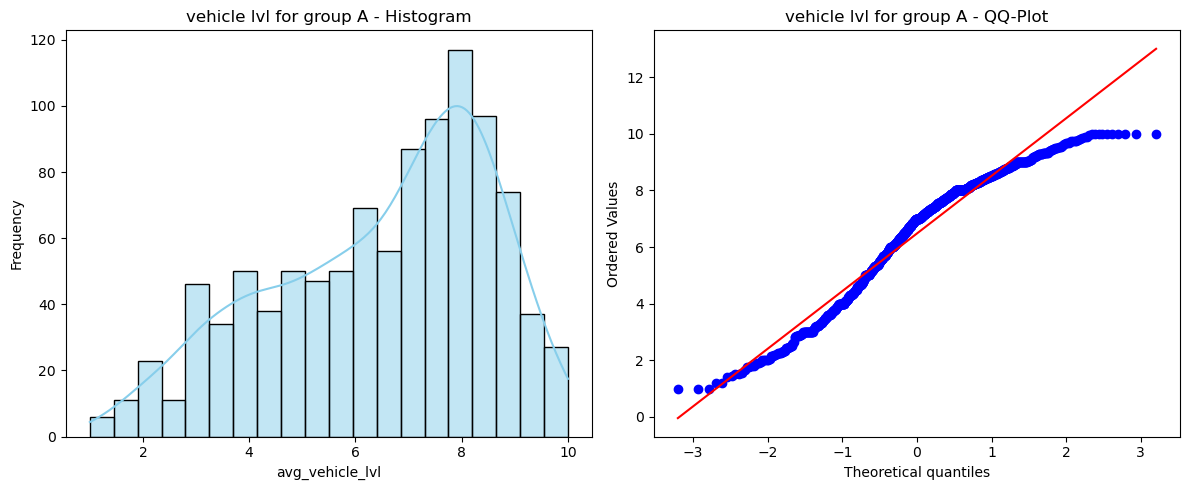

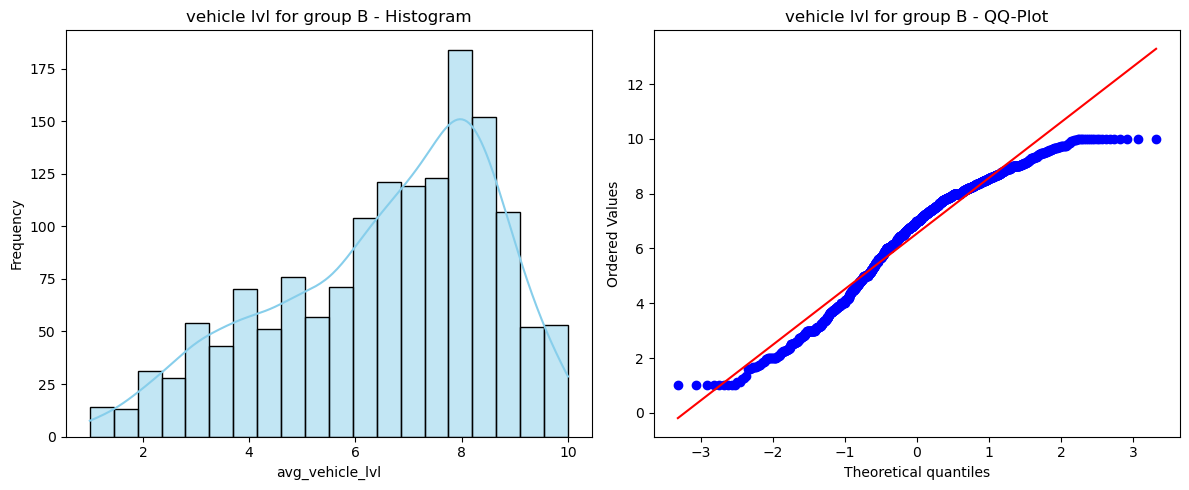

In [96]:
plot_distribution_analysis(group_a, title_prefix="vehicle lvl for group A")
plot_distribution_analysis(group_b, title_prefix="vehicle lvl for group B")

#### Metric Distribution & Statistical Test Selection for metric - vehicle lvl

Based on the results of the Normal test and visualization, the distribution of the metric *vehicle lvl* in both groups does not follow a normal distribution. As a result, standard parametric methods (e.g., t-test) are not suitable for computing the p-value.

Instead, I will use **bootstrapping** to estimate the distribution of the difference between groups and calculate a confidence interval for this difference.

## Applying Statistical Tests to the A/B Test

**Product hypothesis:**  
- The change led to a decrease in player effectiveness in Group A, reflected by lower damage dealt per battle among new players compared to the control group. 
- The change led to a decrease in player effectiveness in Group A, reflected by lower kills per battle among new players compared to the control group. 
- The change negatively impacted player progression, with players in Group A having lower vehicle levels 

**Statistical tests applied:** Bootstrap with confidence intervals

Parameters:
- Number of bootstrap iterations: 1000  
- Significance level (α): 0.05

The analysis accounts for the fact that the initial samples were unbalanced in terms of the number of players in each group.

### Analysis of the mean damage dealt per battle

In [107]:
n_bootstrap = 1000
group_a, group_b = get_column_by_player_groups(df_sample_data, "avg_damage_per_battle")

# Calculate bootstrap confidence intervals
ci_low, ci_high, significant, diff_distribution = bootstrap_diff_mean(
    group_a, group_b, n_bootstrap
)

mean_A, mean_B = np.mean(group_a), np.mean(group_b)
median_A, median_B = np.median(group_a), np.median(group_b)

print(
    f"95% Confidence interval of the difference in means (B - A): [{ci_low:.4f}, {ci_high:.4f}]"
)
print(
    "The difference between the groups is statistically significant"
    if significant
    else "There is no statistically significant difference between the groups."
)

95% Confidence interval of the difference in means (B - A): [-2.7359, 83.3280]
There is no statistically significant difference between the groups.


**Conclusion:**  
Since this interval includes zero, we cannot conclude that there is a statistically significant difference between the groups.  
In simple terms, the data does not provide strong evidence that the change affected the metric.

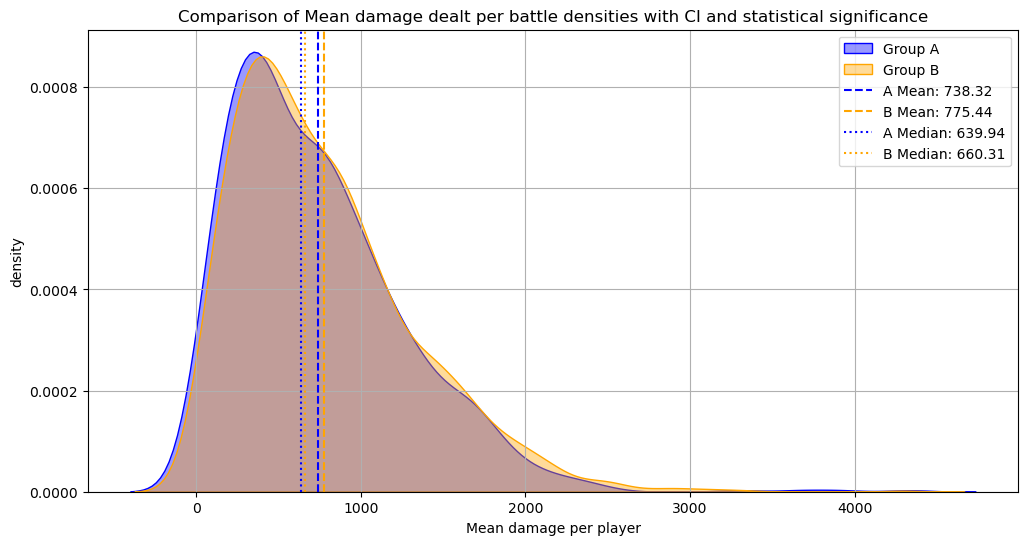

In [117]:
# KDE
plt.figure(figsize=(12, 6))
sns.kdeplot(group_a, fill=True, label="Group A", color="blue", alpha=0.4)
sns.kdeplot(group_b, fill=True, label="Group B", color="orange", alpha=0.4)

plt.axvline(mean_A, color="blue", linestyle="--", label=f"A Mean: {mean_A:.2f}")
plt.axvline(mean_B, color="orange", linestyle="--", label=f"B Mean: {mean_B:.2f}")
plt.axvline(median_A, color="blue", linestyle=":", label=f"A Median: {median_A:.2f}")
plt.axvline(median_B, color="orange", linestyle=":", label=f"B Median: {median_B:.2f}")

plt.title("Comparison of Mean damage dealt per battle densities with CI and statistical significance")
plt.xlabel("Mean damage per player")
plt.ylabel("density")
plt.legend()
plt.grid(True)
plt.show()

### Analysis of the Mean kills made per battle

In [136]:
n_bootstrap = 1000
group_a, group_b = get_column_by_player_groups(df_sample_data, "avg_kills_per_battle")

# Calculate bootstrap confidence intervals
ci_low, ci_high, significant, diff_distribution = bootstrap_diff_mean(
    group_a, group_b, n_bootstrap
)

mean_A, mean_B = np.mean(group_a), np.mean(group_b)
median_A, median_B = np.median(group_a), np.median(group_b)

print(
    f"95% Confidence interval of the difference in means (B - A): [{ci_low:.4f}, {ci_high:.4f}]"
)
print(
    "The difference between the groups is statistically significant"
    if significant
    else "There is no statistically significant difference between the groups."
)

95% Confidence interval of the difference in means (B - A): [0.0021, 0.0675]
The difference between the groups is statistically significant


**Conclusion:**

The 95% bootstrap confidence interval for the difference in means (B − A) is [0.0021, 0.0675].  
Since the interval does not include 0, the difference is **statistically significant** at the 5% level.

**Interpretation**: Group B outperformed Group A, with an estimated average uplift. This suggests that the variant tested in Group A had a **negative impact**.

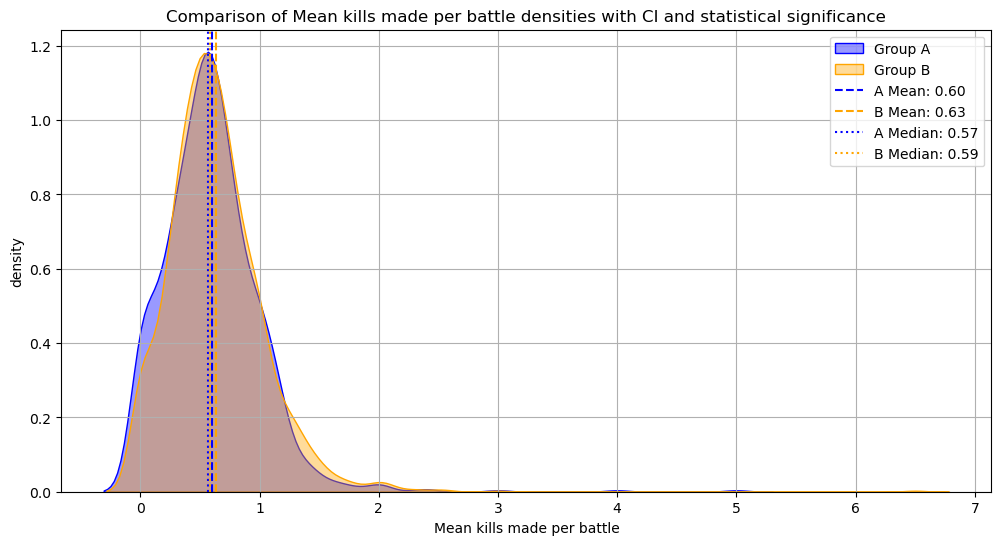

In [141]:
# KDE
plt.figure(figsize=(12, 6))
sns.kdeplot(group_a, fill=True, label="Group A", color="blue", alpha=0.4)
sns.kdeplot(group_b, fill=True, label="Group B", color="orange", alpha=0.4)

plt.axvline(mean_A, color="blue", linestyle="--", label=f"A Mean: {mean_A:.2f}")
plt.axvline(mean_B, color="orange", linestyle="--", label=f"B Mean: {mean_B:.2f}")
plt.axvline(median_A, color="blue", linestyle=":", label=f"A Median: {median_A:.2f}")
plt.axvline(median_B, color="orange", linestyle=":", label=f"B Median: {median_B:.2f}")

plt.title("Comparison of Mean kills made per battle densities with CI and statistical significance")
plt.xlabel("Mean kills made per battle")
plt.ylabel("density")
plt.legend()
plt.grid(True)
plt.show()

### Analysis of the Vehicle levels

In [143]:
n_bootstrap = 1000
group_a, group_b = get_column_by_player_groups(df_sample_data, "avg_vehicle_lvl")

# Calculate bootstrap confidence intervals
ci_low, ci_high, significant, diff_distribution = bootstrap_diff_mean(
    group_a, group_b, n_bootstrap
)

mean_A, mean_B = np.mean(group_a), np.mean(group_b)
median_A, median_B = np.median(group_a), np.median(group_b)

print(
    f"95% Confidence interval of the difference in means (B - A): [{ci_low:.4f}, {ci_high:.4f}]"
)
print(
    "The difference between the groups is statistically significant"
    if significant
    else "There is no statistically significant difference between the groups."
)

95% Confidence interval of the difference in means (B - A): [-0.1017, 0.2157]
There is no statistically significant difference between the groups.


**Conclusion:**  
Since this interval includes zero, we cannot conclude that there is a statistically significant difference between the groups.  
In simple terms, the data does not provide strong evidence that the change affected the metric.

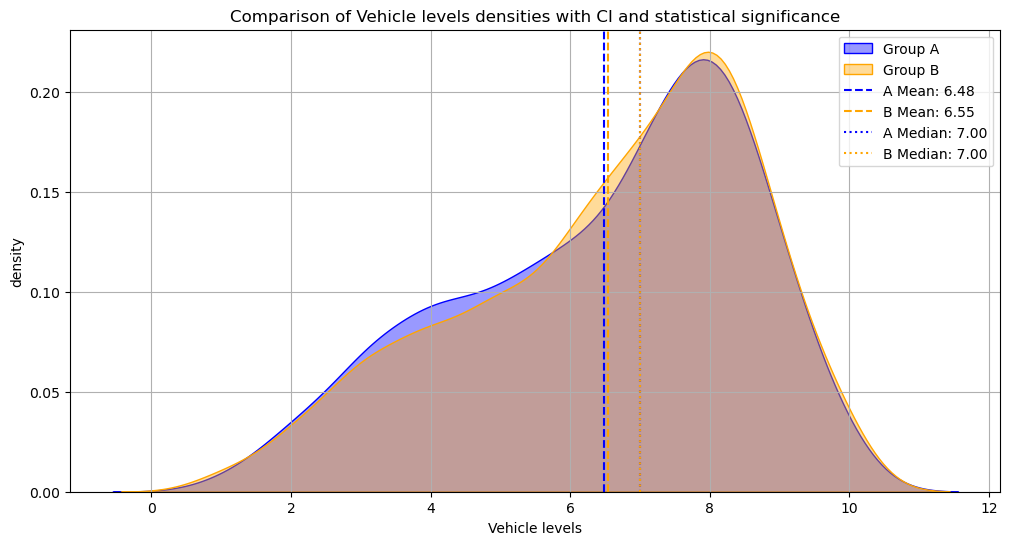

In [149]:
# KDE
plt.figure(figsize=(12, 6))
sns.kdeplot(group_a, fill=True, label="Group A", color="blue", alpha=0.4)
sns.kdeplot(group_b, fill=True, label="Group B", color="orange", alpha=0.4)

plt.axvline(mean_A, color="blue", linestyle="--", label=f"A Mean: {mean_A:.2f}")
plt.axvline(mean_B, color="orange", linestyle="--", label=f"B Mean: {mean_B:.2f}")
plt.axvline(median_A, color="blue", linestyle=":", label=f"A Median: {median_A:.2f}")
plt.axvline(median_B, color="orange", linestyle=":", label=f"B Median: {median_B:.2f}")

plt.title("Comparison of Vehicle levels densities with CI and statistical significance")
plt.xlabel("Vehicle levels")
plt.ylabel("density")
plt.legend()
plt.grid(True)
plt.show()

## A/B Test Analysis Summary

### Key Results

| Metric                        | Result Summary                                      | Conclusion                       |
|------------------------------|-----------------------------------------------------|----------------------------------|
| **DAU (Daily Active Users)** | 95% CI: [150.29, 178.24]                            | **Significantly lower in test** |
| **Retention D7**             | Z = -1.17, p = 0.241                                | No significant difference        |
| **Avg. Time in Battle**      | 95% CI: [-3.66, 8.96]                               | No significant difference        |
| **Battles per Player**       | 95% CI: [7.31, 32.71]                               | **Significantly higher in test**     |
| **Vehicle Levels**           | 95% CI: [-0.1017, 0.2157]                           | No significant difference        |
| **Kills per Battle**         | 95% CI: [0.0021, 0.0675]                            | **Slight increase in test**          |
| **Damage Dealt per Battle**  | 95% CI: [-2.74, 83.33]                              | Not statistically significant    |

---

### Interpretation

- The **test group (A)** shows a **significant decrease in DAU**, which indicates reduced user engagement at the top of the funnel.
- **Retention D7 is not significantly different** between groups (p = 0.24), but the trend is negative.
- Players in the test group who remain tend to **play more battles**, suggesting higher short-term engagement.
- **Combat performance metrics** (kills, damage, time) show minimal or no significant differences.

---

### Hypotheses

1. The test may introduce changes that negatively affect **initial user appeal or first-session experience**, leading to lower DAU.
2. Although D7 retention is not significantly worse, the downward trend combined with lower DAU suggests **reduced overall player lifecycle**.
3. Higher session activity (more battles per player) may indicate **engaging but potentially fatiguing** gameplay.

---

### Recommendations

- **Do not roll out the test** without adjustments.
- Investigate the **early player experience** (tutorial, UX, onboarding) to identify causes of DAU drop.
- Validate Retention trends further with D1/D3/D14 metrics.
- Use **qualitative feedback** (surveys, playtests, session recordings) to understand player sentiment.
- Consider iterating on the test with **targeted improvements to first-session clarity, pacing, and long-term incentives**.

# 2. Impact of the Change on Player Segments

Analyze key metrics such as retention d7 and DAU across segments defined by player status (new vs. returning), vehicle level, and battle duration (high vs. low).

## Analysis DAU

In [184]:
n_bootstrap = 1000
group_a, group_b = get_column_by_player_groups(df_sample_dau[df_sample_dau["new_status"] == "new"], "daily_dau")

# Calculate bootstrap confidence intervals
ci_low, ci_high, significant, diff_distribution = bootstrap_diff_mean(
    group_a, group_b, n_bootstrap
)

mean_A, mean_B = np.mean(group_a), np.mean(group_b)
median_A, median_B = np.median(group_a), np.median(group_b)

print(
    f"95% Confidence interval of the difference in means (B - A): [{ci_low:.4f}, {ci_high:.4f}]"
)
print(
    "The difference between the groups is statistically significant"
    if significant
    else "There is no statistically significant difference between the groups."
)

95% Confidence interval of the difference in means (B - A): [8.2647, 16.3838]
The difference between the groups is statistically significant


In [186]:
n_bootstrap = 1000
group_a, group_b = get_column_by_player_groups(df_sample_dau[df_sample_dau["new_status"] == "old"], "daily_dau")

# Calculate bootstrap confidence intervals
ci_low, ci_high, significant, diff_distribution = bootstrap_diff_mean(
    group_a, group_b, n_bootstrap
)

mean_A, mean_B = np.mean(group_a), np.mean(group_b)
median_A, median_B = np.median(group_a), np.median(group_b)

print(
    f"95% Confidence interval of the difference in means (B - A): [{ci_low:.4f}, {ci_high:.4f}]"
)
print(
    "The difference between the groups is statistically significant"
    if significant
    else "There is no statistically significant difference between the groups."
)

95% Confidence interval of the difference in means (B - A): [140.2324, 164.6765]
The difference between the groups is statistically significant


**Conclusion**:

DAU Decrease Across User Segments
The DAU metric decreased significantly in both user segments:

New users (players who joined the game after the change)
Returning users (players who had already played before the test)
This indicates that the negative impact of the tested change was not limited to a specific cohort, but rather affected the overall player base.

## Analysis Retention d7

In [206]:
retained_a, retained_b = get_column_by_player_groups(df_retentiond7_test[df_retentiond7_test["new_status"] == "old"], "retained_users")
total_a, total_b = get_column_by_player_groups(df_retentiond7_test[df_retentiond7_test["new_status"] == "old"], "total_users")

retained = [retained_a, retained_b]
total = [total_a, total_b] 

z_stat, p_value = proportions_ztest(retained, total)

print(f"Z-Statistics: {z_stat}, p_value: {p_value}")
print(
    "The difference between the groups is statistically significant"
    if p_value < 0.05
    else "There is no statistically significant difference between the groups."
)

Z-Statistics: [0.30333163], p_value: [0.76163715]
There is no statistically significant difference between the groups.


In [208]:
retained_a, retained_b = get_column_by_player_groups(df_retentiond7_test[df_retentiond7_test["new_status"] == "new"], "retained_users")
total_a, total_b = get_column_by_player_groups(df_retentiond7_test[df_retentiond7_test["new_status"] == "new"], "total_users")

retained = [retained_a, retained_b]
total = [total_a, total_b] 

z_stat, p_value = proportions_ztest(retained, total)

print(f"Z-Statistics: {z_stat}, p_value: {p_value}")
print(
    "The difference between the groups is statistically significant"
    if p_value < 0.05
    else "There is no statistically significant difference between the groups."
)

Z-Statistics: [-2.3081254], p_value: [0.02099216]
The difference between the groups is statistically significant


**Conclusion**:

Retention for new users showed a statistically significant decline.
Combined with the decrease in DAU, this suggests that engagement metrics dropped notably for new players after the change.

This signals a potential issue in the early player experience introduced by the tested feature.